<a href="https://colab.research.google.com/github/ojaswital/Deep-Learning/blob/main/rsna_gan_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSNA Pneumonia GAN Training Notebook
This notebook trains a 2D-DCGAN on the RSNA Pneumonia dataset.

## 1. 🚀 Setup & Dependencies

In [1]:
# 1.1 Check GPU
!nvidia-smi

# 1.2 Install required packages
!pip install torch torchvision pytorch_fid pydicom

Thu Jun 19 18:16:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. ⚙️ Kaggle API & Drive Mount

In [2]:
# 2.5 (Optional) Mount Google Drive for checkpoints
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2.2 Unzip & organize
#!unzip /content/drive/MyDrive/rsna-pneumonia-detection-challenge.zip -d /content/drive/MyDrive/rsna-pneumonia-detection-challenge

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  in

## 3. 🗂️ Data Preparation & Preprocessing

In [9]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pydicom, torch

# 3.1 Read CSV of labels
df = pd.read_csv('/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df['has_pneumonia'] = df['Target'] > 0

# 3.2 PyTorch Dataset
class RSNADataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df.drop_duplicates(subset='patientId')
        self.root = root
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize(256),
            #transforms.CenterCrop(256),
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        pid = self.df.iloc[idx].patientId
        dcm = pydicom.dcmread(f"{self.root}/{pid}.dcm")
        img = dcm.pixel_array.astype('float32')
        img = self.transform(img[..., None])
        return img

dataset = RSNADataset(df, '/content/drive/MyDrive/rsna-pneumonia-detection-challenge/stage_2_train_images')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([64, 1, 64, 64])
Dtype: torch.float32 Min/Max: -1.0 1.0


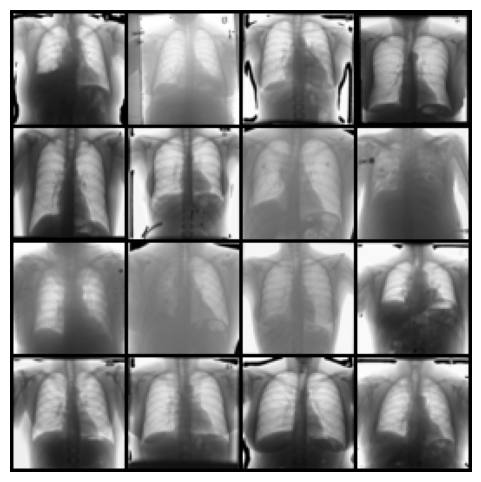

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# 1. Grab one batch
batch = next(iter(dataloader))      # batch is a tensor of shape [B, C, H, W], here [64, 1, 256, 256]
print("Batch shape:", batch.shape)
print("Dtype:", batch.dtype, "Min/Max:", batch.min().item(), batch.max().item())

# 2. Visualize a grid of the first 16 images
grid = vutils.make_grid(batch[:16], nrow=4, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.show()

## 4. 🏗️ Define Your GAN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm

# -----------------------------------------------------------------------------
# Generator (unchanged except no change to support WGAN)
# -----------------------------------------------------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf,     1,   4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)
        '''
class Generator256(nn.Module):
    def __init__(self, z_dim=100, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            # 1→4
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(),

            # 4→8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(),

            # 8→16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(),

            # 16→32
            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),   nn.ReLU(),

            # 32→64
            nn.ConvTranspose2d(ngf,    ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),    nn.ReLU(),

            # 64→128  ← new
            nn.ConvTranspose2d(ngf//2, ngf//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//4),    nn.ReLU(),

            # 128→256 ← new
            nn.ConvTranspose2d(ngf//4,    1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)
'''

# -----------------------------------------------------------------------------
# Discriminator with spectral norm and no sigmoid
# -----------------------------------------------------------------------------
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(1, ndf,    4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=False),

            spectral_norm(nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=False),

            spectral_norm(nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=False),

            spectral_norm(nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=False),

            spectral_norm(nn.Conv2d(ndf*8, 1,    4, 1, 0, bias=False)),
            # outputs a single-channel feature‐map
        )
    def forward(self, x):
        x = self.net(x)                         # [B,1,H,W]
        x = F.adaptive_avg_pool2d(x, (1,1))     # [B,1,1,1]
        return x.view(-1)                       # [B]  <-- raw scores

# -----------------------------------------------------------------------------
# Gradient penalty for WGAN-GP
# -----------------------------------------------------------------------------
def gradient_penalty(D, real, fake, λ=10.0):
    B, C, H, W = real.shape
    α = torch.rand(B, 1, 1, 1, device=real.device)
    interp = (α * real + (1 - α) * fake).requires_grad_(True)
    d_interp = D(interp)
    grads = grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    grad_norm = grads.view(B, -1).norm(2, dim=1)
    return λ * ((grad_norm - 1) ** 2).mean()


Discriminator now outputs raw real-valued scores (no Sigmoid).

Spectral norm wraps every conv in D to keep its Lipschitz constant ≤1.

gradient_penalty() enforces the 1-Lipschitz constraint softly via an extra loss term.

WGAN losses:

𝐿
𝐷
=
𝐸
[
𝐷
(
fake
)
]
−
𝐸
[
𝐷
(
real
)
]
+
𝜆

G
P
L
D
​
 =E[D(fake)]−E[D(real)]+λGP

𝐿
𝐺
=
−

𝐸
[
𝐷
(
fake
)
]
L
G
​
 =−E[D(fake)]

With this in place, your discriminator can never collapse to 0/1 extremes, and your generator will always get a useful gradient signal.









## 5. 🔄 Training Loop

In [ ]:
# -----------------------------------------------------------------------------
# Training loop
# -----------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)

optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
optD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5,0.999))

z_dim = 100
num_epochs = 50

lossD_vals, lossG_vals = [], []

for epoch in range(num_epochs):
    epoch_d, epoch_g = 0.0, 0.0

    for real in dataloader:
        real = real.to(device)
        B = real.size(0)
        # (optional) instance noise + one‐sided smoothing
        real_noisy = real + 0.05*torch.randn_like(real)
        labels_real = torch.full((B,), 0.9, device=device)

        # ----- Train Discriminator -----
        D.zero_grad()
        # 1) real
        d_real = D(real_noisy).mean()               # E[D(real)]
        # 2) fake
        z = torch.randn(B, z_dim, 1, 1, device=device)
        fake = G(z)
        fake_noisy = fake.detach() + 0.05*torch.randn_like(fake)
        d_fake = D(fake_noisy).mean()               # E[D(fake)]
        # 3) gradient penalty
        gp = gradient_penalty(D, real, fake.detach())

        lossD = d_fake - d_real + gp                # WGAN-GP
        lossD.backward()
        optD.step()

        # ----- Train Generator -----
        G.zero_grad()
        g_out = D(fake).mean()                      # E[D(fake)]
        lossG = -g_out                              # WGAN generator loss
        lossG.backward()
        optG.step()

        epoch_d += lossD.item()
        epoch_g += lossG.item()

        with torch.no_grad():
            real_score = D(real).mean().item()
            fake_score = D(fake).mean().item()
            gp_term    = gradient_penalty(D, real, fake).item()
            print(f"  D(real)={real_score:.3f},  D(fake)={fake_score:.3f},  GP={gp_term:.3f}")

    # record and print avg per-epoch
    avgD, avgG = epoch_d/len(dataloader), epoch_g/len(dataloader)
    lossD_vals.append(avgD)
    lossG_vals.append(avgG)
    print(f"Epoch [{epoch+1}/{num_epochs}]  LossD: {avgD:.4f}  LossG: {avgG:.4f}")
    torch.save(G.state_dict(), f"/content/drive/MyDrive/rsna-pneumonia-detection-challenge/checkpoints/G_epoch{epoch+1}.pth")

Epoch [1/50]  LossD: -11.6956  LossG: 5.0732
Epoch [2/50]  LossD: -0.3824  LossG: 1.7474
Epoch [3/50]  LossD: -0.2373  LossG: 2.1854
Epoch [4/50]  LossD: -0.5905  LossG: 2.4619


In [ ]:
# Plot loss
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs+1))
plt.figure(figsize=(8,5))
plt.plot(epochs, lossD_vals, label='Discriminator Loss')
plt.plot(epochs, lossG_vals, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## 6. 📊 Evaluation & Visualization

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Generate samples
with torch.no_grad():
    z = torch.randn(64, z_dim, 1, 1, device=device)
    samples = G(z).cpu()

# Display a grid
grid = vutils.make_grid(samples, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(grid.permute(1,2,0), cmap='gray')

## 7. 🎯 FID / KID Metrics

In [ ]:
# After saving real & fake images to folders:
!python -m pytorch_fid /content/real_images /content/fake_images